In [50]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from astropy.table import Table
import numpy.ma as ma
from skimage.filters import gaussian
import sys
sys.path.insert(1,"/Users/nityaravi/Documents/Github/RotationCurves/spirals/")
from DRP_rotation_curve import extract_data


In [43]:
matplotlib.rcParams['savefig.dpi'] = 300
matplotlib.rcParams['figure.dpi'] = 100

In [5]:
folder = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/output_files/DR17/CURRENT_MASTER_TABLE/'
fn = folder + 'H_alpha_HIvel_BB_extinction_H2_MxCG_R90_v3p5_Z_SFR_Portsmouthflux_Zglob.fits'
MANGA_FOLDER = '/Users/nityaravi/Documents/Research/RotationCurves/data/manga/'
NSA_FILENAME = '/Users/nityaravi/Documents/Research/RotationCurves/data/nsa_v1_0_1.fits'
VEL_MAP_FOLDER = MANGA_FOLDER + 'DR17/'

In [180]:
t = Table.read(fn, format='fits')
t_dict = {}
for i in range(0, len(t)):
    gal_ID = t['plateifu'][i]
    t_dict[gal_ID] = i
t[t_dict['11011-3702']]

plate,ifudsgn,plateifu,mangaid,versdrp2,versdrp3,verscore,versutil,versprim,platetyp,srvymode,objra,objdec,ifuglon,ifuglat,ifura,ifudec,ebvgal,nexp,exptime,drp3qual,bluesn2,redsn2,harname,frlplug,cartid,designid,cenra,cendec,airmsmin,airmsmed,airmsmax,seemin,seemed,seemax,transmin,transmed,transmax,mjdmin,mjdmed,mjdmax,gfwhm,rfwhm,ifwhm,zfwhm,mngtarg1,mngtarg2,mngtarg3,catidnum,plttarg,manga_tileid,nsa_iauname,ifudesignsize,ifutargetsize,ifudesignwrongsize,z,zmin,zmax,szmin,szmax,ezmin,ezmax,probs,pweight,psweight,psrweight,sweight,srweight,eweight,esweight,esrweight,nsa_field,nsa_run,nsa_camcol,nsa_version,nsa_nsaid,nsa_nsaid_v1b,nsa_z,nsa_zdist,nsa_sersic_absmag [7],nsa_elpetro_absmag [7],nsa_elpetro_amivar [7],nsa_sersic_mass,nsa_elpetro_mass,nsa_elpetro_ba,nsa_elpetro_phi,nsa_extinction [7],nsa_elpetro_th50_r,nsa_petro_th50,nsa_petro_flux [7],nsa_petro_flux_ivar [7],nsa_elpetro_flux [7],nsa_elpetro_flux_ivar [7],nsa_sersic_ba,nsa_sersic_n,nsa_sersic_phi,nsa_sersic_th50,nsa_sersic_flux [7],nsa_sersic_flux_ivar [7],smoothness_score,nsa_elpetro_th90,v_sys,v_sys_err,ba,ba_err,x0,x0_err,y0,y0_err,phi,phi_err,v_max,v_max_err,r_turn,r_turn_err,chi2,alpha,alpha_err,Rmax,M,M_err,fit_flag,Sigma_disk,Sigma_disk_err,R_disk,R_disk_err,rho_bulge,rho_bulge_err,R_bulge,R_bulge_err,M90_disk,M90_disk_err,M_disk,M_disk_err,chi2_disk,logHI,logHIlim,WF50,WF50_err,DL_ttype,vis_tidal,b,b_err,M_R90,M_R90_err,fit_function,A_g,A_r,logH2,R90_kpc,v_3p5,v_3p5_err,NSA_plate,NSA_fiberID,NSA_MJD,logH2_CG,logH2_CG_err,logH2_M,Z,Z_err,M_Z,M_Z_err,grad_Z,grad_Z_err,Z_0,Z_0_err,SFR,sSFR,SFR_err,sSFR_err,Flux_OII_3726,Flux_OII_3726_Err,Flux_OII_3728,Flux_OII_3728_Err,Flux_OIII_4958,Flux_OIII_4958_Err,Flux_OIII_5006,Flux_OIII_5006_Err,Flux_NII_6547,Flux_NII_6547_Err,Flux_NII_6583,Flux_NII_6583_Err,Flux_Ha_6562,Flux_Ha_6562_Err,Flux_Hb_4861,Flux_Hb_4861_Err,CMD_class,rabsmag_NSA,param_H2,param_H2_err,Z_map,Z_err_map,M_Z_map,M_Z_err_map
int64,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,bytes32,float64,float64,float64,float64,float64,float64,float64,int64,float64,int64,float64,float64,bytes53,int64,bytes32,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,int64,int64,int64,int64,bytes32,int64,bytes19,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,bytes6,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
11011,3702,11011-3702,1-321127,v3_1_1,v3_1_1,v1_9_1,v5_5_36,v2_9,APOGEE-2&MaNGA,MaNGA dither,216.729290026,48.0998981802,87.7919919663,61.9967871339,216.72929,48.099898,0.0219919,9,8100.73,0,20.7804,46.7142,ma081,27,4,11652,217.30728,48.938065,1.03703,1.06679,1.15371,1.36872,1.48051,1.54698,0.841774,0.87204,0.910849,58575,58575,58575,2.55149,2.48224,2.4606,2.44156,1168,0,0,1,plateTargets-1.par,6329,J142655.02+480559.6,37,37,0,0.025556073,0.020718733,0.027553614,0.040786084,0.045009885,0.020718733,0.027553614,0.67973006,1.6151279,0.63629895,0.68812716,-999.

In [211]:
def find_center(vel_map):
    '''
    Locate the center of the galaxy velocity map, defined as the position with
    the velocity value closest to 0.


    PARAMETERS
    ==========

    vel_map : numpy ndarray of shape (n,n)
        Masked H-alpha velocity map


    RETURNS
    =======

    center : numpy ndarray of shape (,2)
        Center coordinates of velocity map, [y,x] or [row, column]
    '''

    ############################################################################
    # Transform velocity map so that the 0th value is the maximum in the array
    # (including the masked points)
    #---------------------------------------------------------------------------
    neg_map = -np.abs(vel_map)
    shifted_neg_map = neg_map + np.abs(ma.min(vel_map))

    # Set all masked values to have a value of -1
    shifted_neg_map[vel_map.mask] = -1
    ############################################################################


    ############################################################################
    # Find the location of the maximum in the shifted negative map
    #---------------------------------------------------------------------------
    smoothed_map = gaussian(shifted_neg_map, sigma=2)

    center = np.unravel_index(np.argmax(smoothed_map), smoothed_map.shape)
    ############################################################################

    return center

def find_phi(center_coords, phi_angle, vel_map):
    '''
    Find a point along the semi-major axis that has data to determine if phi
    needs to be adjusted.  (This is necessary because the positive y-axis is
    defined as being along the semi-major axis of the positive velocity side of
    the velocity map.)


    PARAMETERS
    ==========

    center_coords : tuple
        Coordinates of the center of the galaxy

    phi_angle : float
        Initial rotation angle of the galaxy, E of N.  Units are degrees.

    vel_map : masked ndarray of shape (n,n)
        Masked H-alpha velocity map


    RETURNS
    =======

    phi_adjusted : float
        Rotation angle of the galaxy, E of N, that points along the positive
        velocity sector.  Units are radians.
    '''
    
    spax_jump = []
    spax = []
    
    # Convert phi_angle to radians
    phi = phi_angle*np.pi/180.
    
    print('phi: ', phi)

    # Extract "systemic" velocity (velocity at center spaxel)
    v_sys = vel_map[center_coords]

    f = 0.4

    checkpoint_masked = True

    while checkpoint_masked and not vel_map.mask.all():
        delta_x = center_coords[1]*f
        delta_y = delta_x/np.tan(phi)
        semi_major_axis_spaxel = np.array([int(center_coords[0] + delta_y), int(center_coords[1] - delta_x)])
        
        print('spax jump: ', semi_major_axis_spaxel)
        spax_jump.append([semi_major_axis_spaxel[0], semi_major_axis_spaxel[1]])
        
        in_map = True # check if pt along semi major axis is in the vel map
        
        for i in range(len(semi_major_axis_spaxel)):
            if semi_major_axis_spaxel[i] < 0:
                in_map = False
            elif semi_major_axis_spaxel[i] >= vel_map.shape[i]:
                in_map = False
        
        '''
        print('spax: ', semi_major_axis_spaxel)
        spax.append([semi_major_axis_spaxel[0], semi_major_axis_spaxel[1]])

        # Check value along semi-major axis
        if vel_map.mask[tuple(semi_major_axis_spaxel)] == 0:
            checkpoint_masked = False
        else:
            f *= 0.9'''
        
        if in_map == False:
            f *= 0.9
        elif vel_map.mask[tuple(semi_major_axis_spaxel)] == 0:
            checkpoint_masked=False
        else:
            f *= 0.9
            

    if vel_map.mask.all() or vel_map[tuple(semi_major_axis_spaxel)] - v_sys >= 0:
        phi_adjusted = phi
        print('no flip')
    else:
        phi_adjusted = phi + np.pi
        print('flip')

    print('new phi: ', phi_adjusted)

    return phi_adjusted, spax_jump, spax

In [229]:
gal_ID = '10519-12702'

i_t = t_dict[gal_ID]
phi_angle = t['nsa_elpetro_phi'][i_t]


maps = extract_data(VEL_MAP_FOLDER,
                    gal_ID,
                    ['Ha_vel', 'Ha_flux', 'Ha_sigma', 'r_band'])

vel = maps['Ha_vel']
vel_mask = maps['Ha_vel_mask']
vel_ivar = maps['Ha_vel_ivar']

Ha_flux = maps['Ha_flux']
Ha_flux_mask = maps['Ha_flux_mask']
Ha_flux_ivar = maps['Ha_flux_ivar']

Ha_sigma_ivar = maps['Ha_sigma_ivar']


vel_mask = np.logical_or(vel_mask > 0, np.abs(Ha_flux*np.sqrt(Ha_flux_ivar)) < 5)

mvel = ma.array( vel, mask=vel_mask)
    

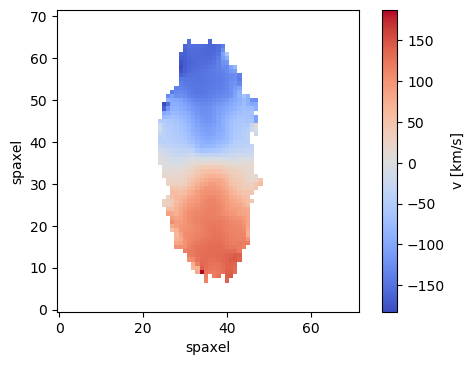

In [230]:
plt.imshow(mvel, cmap='coolwarm')
plt.colorbar(label='v [km/s]')
plt.xlabel('spaxel')
plt.ylabel('spaxel')
plt.gca().invert_yaxis()

In [231]:
center = find_center(mvel)
center

(35, 29)

In [232]:
newphi, spax_jump, spax = find_phi(center, phi_angle, mvel)
np.degrees(newphi)

phi:  0.03122830364130854
delta:  11.600000000000001 371.3371397889078
spax jump:  [406  17]
delta:  10.440000000000001 334.203425810017
spax jump:  [369  18]
delta:  9.396000000000003 300.78308322901535
spax jump:  [335  19]
delta:  8.456400000000002 270.7047749061138
spax jump:  [305  20]
delta:  7.610760000000002 243.6342974155024
spax jump:  [278  21]
delta:  6.849684000000002 219.27086767395218
spax jump:  [254  22]
delta:  6.164715600000003 197.343780906557
spax jump:  [232  22]
delta:  5.548244040000003 177.60940281590132
spax jump:  [212  23]
delta:  4.993419636000003 159.8484625343112
spax jump:  [194  24]
delta:  4.494077672400002 143.86361628088005
spax jump:  [178  24]
delta:  4.044669905160002 129.47725465279206
spax jump:  [164  24]
delta:  3.6402029146440014 116.52952918751284
spax jump:  [151  25]
delta:  3.2761826231796016 104.87657626876157
spax jump:  [139  25]
delta:  2.9485643608616416 94.38891864188541
spax jump:  [129  26]
delta:  2.6537079247754773 84.9500267776

181.78925

In [222]:
spax_jump

[[-714, 26],
 [-639, 28],
 [-571, 29],
 [-510, 31],
 [-455, 32],
 [-406, 33],
 [-362, 34],
 [-322, 35],
 [-286, 36],
 [-254, 37],
 [-224, 37],
 [-198, 38],
 [-175, 39],
 [-153, 39],
 [-134, 39],
 [-117, 40],
 [-102, 40],
 [-88, 41],
 [-75, 41],
 [-64, 41],
 [-54, 41],
 [-45, 42],
 [-36, 42],
 [-29, 42],
 [-22, 42],
 [-16, 42],
 [-11, 42],
 [-6, 42],
 [-2, 43],
 [1, 43],
 [5, 43],
 [8, 43],
 [11, 43],
 [13, 43]]

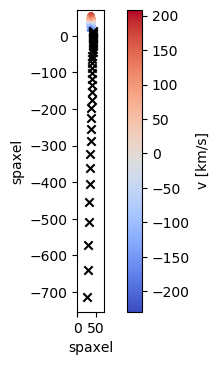

In [224]:
plt.imshow(mvel, cmap='coolwarm')
plt.colorbar(label='v [km/s]')
plt.xlabel('spaxel')
plt.ylabel('spaxel')
for i in range(0,len(spax_jump)):
#    plt.scatter(spax_jump[i][1], spax_jump[i][0], marker='x', color='cyan')
    plt.scatter(spax_jump[i][1], spax_jump[i][0], marker='x', color='k')
plt.gca().invert_yaxis()

plt.show()

In [210]:
mvel[(37,20)] - mvel[center]

-95.420074